## Predicting Property Values

Oliver Ton - 03.30.2022

### Executive Summary

The goal of this project is to acquire Zillow regarding single unit porperty values from 2017, cleaning and analyzing it to create supervised machine learning models. These models were used to predict property tax values of single unit properties.

### Project Overview

- Python scripts were used to automate the process of acquiring, preparing and explorign the data
- The data was cleaned by replacing null values, dropping duplicates, encoding new features and one hot encoding features
    - These steps were taken to create the best performing model (mvp)
    - Outliers in the data were analyzed as weel as the distributions of variables explored in depth 
- The data was split into train, validate and test into 3 dataframes beofre modeling to avoid data leakage and maintain data integrity 
- Recursive feature engineering was utilized to select the top features to be included in the models used to predict property values
- The target variables, tax value, is continuous, used the following regression algorithms to create models that perform better than the baseline:
    - OLS Linear Regression
    - Lasso + Lars
    - Tweedie Regressor GLM
    - Polynomial Regression
- The best model (mvp) was fitted on the test data to predict propter values

In [1]:
#Import
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

import wrangle as w
import evaluate as eva
import explore as exp
import model as m

## Wrangle

In [2]:
#Data acquire from Codeup database and then return Zillow data into a dataframe and create a csv 
df = w.get_zillow_data()

In [3]:
#Checking if the function above run as intended 
df.head()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips,taxamount
0,14372057,2.0,2.5,1348.0,343967.0,1979.0,6059.0,3628.14
1,13929199,3.0,2.0,1221.0,367034.0,1955.0,6059.0,4589.60
2,12430095,3.0,2.0,1462.0,79713.0,1950.0,6037.0,1269.65
3,13033318,2.0,1.0,768.0,270458.0,1926.0,6037.0,3373.09
4,12079615,4.0,4.0,3696.0,940251.0,1989.0,6037.0,10313.18


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52441 non-null  int64  
 1   bedroomcnt                    52441 non-null  float64
 2   bathroomcnt                   52441 non-null  float64
 3   calculatedfinishedsquarefeet  52359 non-null  float64
 4   taxvaluedollarcnt             52440 non-null  float64
 5   yearbuilt                     52325 non-null  float64
 6   fips                          52441 non-null  float64
 7   taxamount                     52437 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 3.6 MB


In [5]:
#Checking for null values
w.miss_dup_values(df)

Your selected dataframe has 8 columns.
There are 4 columns that have missing values.
  
** There are 121 duplicate rows that represents 0.23% of total Values**


,Missing Values,% of Total Values
yearbuilt,116,0.2
calculatedfinishedsquarefeet,82,0.2
taxamount,4,0.0
taxvaluedollarcnt,1,0.0


In [6]:
#Clean zillow data: rename columns, drop any duplicates and null values
df = w.clean_zillow(df)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52196 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   parcel_id        52196 non-null  object 
 1   number_bedroom   52196 non-null  float64
 2   number_bathroom  52196 non-null  float64
 3   sqft             52196 non-null  float64
 4   tax_value        52196 non-null  float64
 5   geographic_code  52196 non-null  int64  
 6   tax_amount       52196 non-null  float64
 7   age              52196 non-null  float64
 8   tax_rate         52196 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.0+ MB


In [8]:
#Checking again for null values
w.miss_dup_values(df)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values


In [9]:
#Remove rows with outlier
df = w.remove_outlier(df)

In [10]:
#Split the data into 3 dataframes - train, validate and test
#Target variable - tax_value
target = 'tax_value'
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = w.split_data(df, target)

X_train -> (28840, 8)               y_train->(28840,)
X_validate -> (12360, 8)         y_validate->(12360,) 
X_test -> (10300, 8)                  y_test>(10300,)


## Explore

In [11]:
#Putting our features columns into a list
cols = ['sqft','number_bathroom','number_bedroom','geographic_code','age']

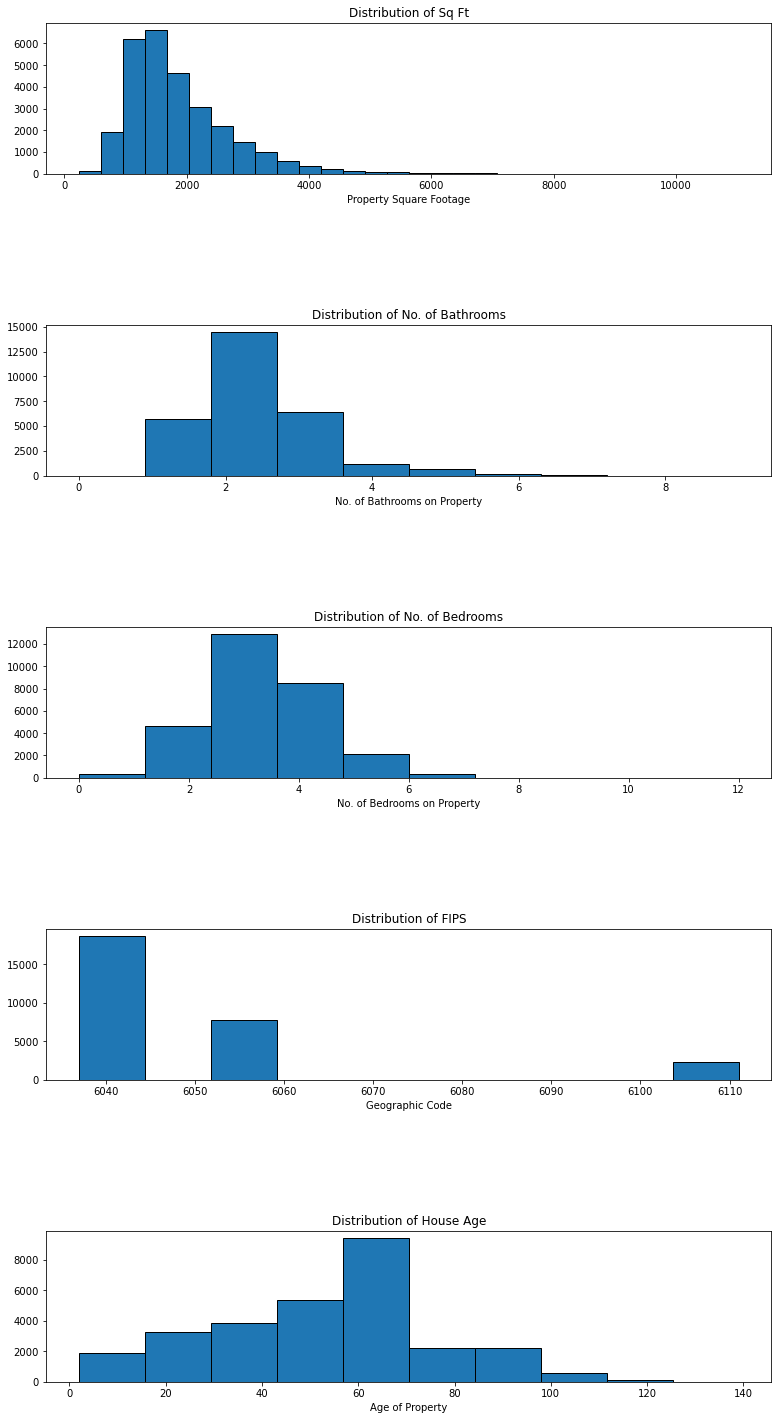

In [12]:
#Checking distributions of our selected features/univariate exploration
exp.distribution_plot(train,cols)

<AxesSubplot:title={'center':'Feautures Correlating with Value'}>

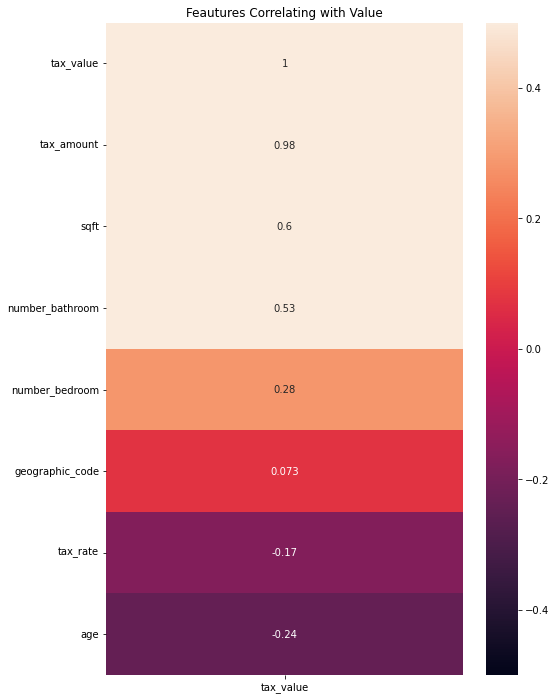

In [13]:
#Heatmap
exp.get_zillow_heatmap(train)

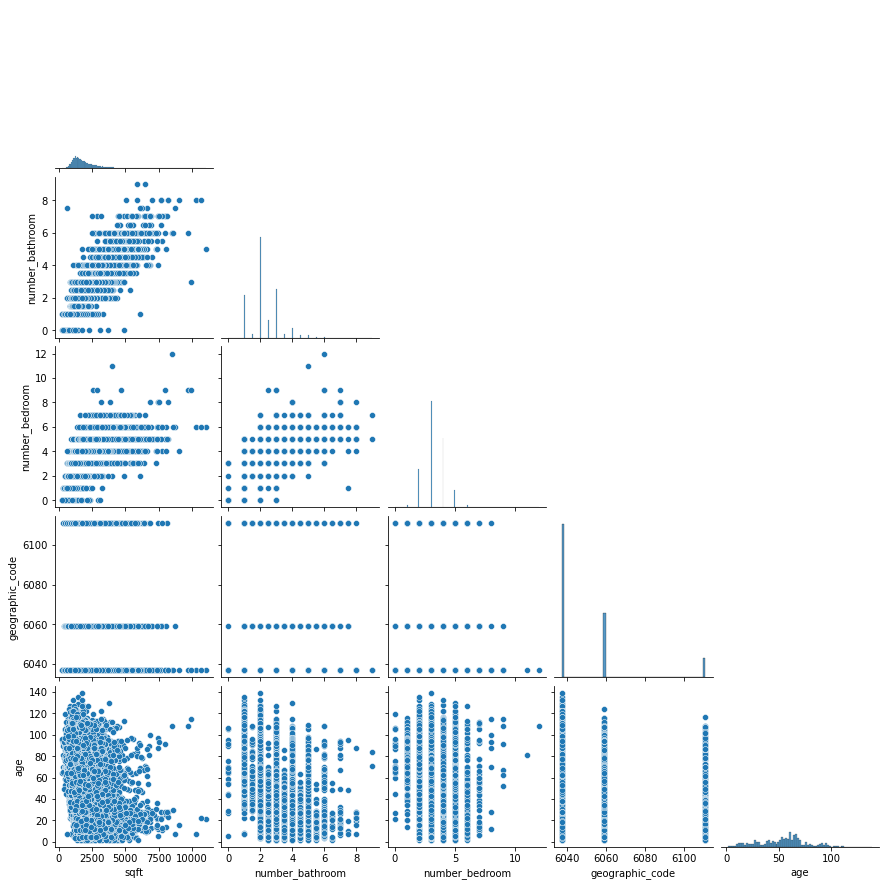

In [14]:
#Create a plots and histograms
exp.plot_pairplot(train, cols, hue=None)

## Statistical Test

In [15]:
# a t-test for bedrooms and value
null_hypothesis = "Houses with 3 bedrooms or more and houses with less than 3 bedrooms are independent to value of home"
alternative_hypothesis = "Houses with 3 bedrooms or more and houses with less than 3 bedrooms are related to value of home"
α = 0.05 #a for alpha 
three_or_more_beds = train[train.number_bedroom>=3]
less_than_three_beds = train[train.number_bedroom<3]
t, p = stats.ttest_ind(three_or_more_beds.tax_value, less_than_three_beds.tax_value)

if p < α:
    print(f'Reject null hypothesis that: {null_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis}')

Reject null hypothesis that: Houses with 3 bedrooms or more and houses with less than 3 bedrooms are independent to value of home


The p-value is: 2.3757632248388324e-133. There is 0.0% chance that we see these results by chance.
t = 24.7


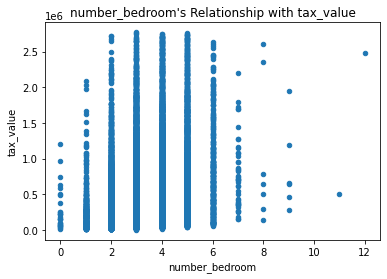

In [16]:
#bedrooms and tax_value
exp.correlation_exploration(train, 'number_bedroom', 'tax_value',t ,p)

In [17]:
# a t test for bathrooms and value, I picked 3 because the mean was over 2. 
# The results suggest they are related to each other.
null_hypothesis = "Houses with 3 bathrooms or more and houses with less than 3 bathrooms are independent to value of home"
alternative_hypothesis = "Houses with 3 bathrooms or more and houses with less than 3 bathrooms are related to value of home"
a = 0.05 #a for alpha 

three_or_more_baths = train[train.number_bathroom>=3]
less_than_three_baths = train[train.number_bathroom<3]
t, p = stats.ttest_ind(three_or_more_baths.tax_value, less_than_three_baths.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Houses with 3 bathrooms or more and houses with less than 3 bathrooms are independent to value of home


The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
t = 76.79


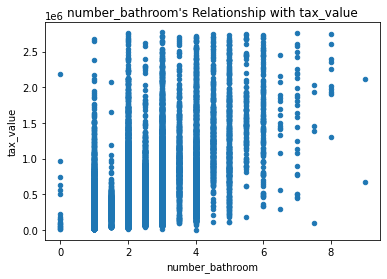

In [18]:
#bathrooms and tax_value
exp.correlation_exploration(train, 'number_bathroom', 'tax_value',t ,p)

In [19]:
# a t test for age, I picked 10 because I would say any house made within the decade is considered fairly new. 
# The results suggest there is not much of a difference in value of homes depending on age. 
null_hypothesis = "House age is independent to value of home"
alternative_hypothesis = "A house being 10 years or older, or less than 10 years, have an affect on value"
a = 0.05 #a for alpha 

old_houses = train[train.age>=10]
new_houses = train[train.age<10]
t, p = stats.ttest_ind(old_houses.tax_value, new_houses.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: House age is independent to value of home


The p-value is: 9.595939695866557e-121. There is 0.0% chance that we see these results by chance.
t = -23.48


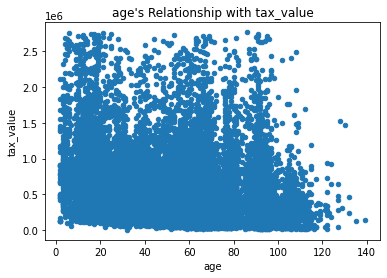

In [20]:
#age and tax_value
exp.correlation_exploration(train, 'age', 'tax_value', t, p)

In [21]:
# t test for square footage and value, I used 1800 sqft because it is roughly the mean area of all selected properties.
# The results suggest they are related to each other.
null_hypothesis = "Values of houses more and less square footage independent to value of home"
alternative_hypothesis = "Values of houses more and less square footage not independent to value of home"
a = 0.05 #a for alpha 

bigger_houses = train[train.sqft>=1800]
smaller_houses = train[train.sqft<1800]
t, p = stats.ttest_ind(bigger_houses.tax_value, smaller_houses.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Values of houses more and less square footage independent to value of home


The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
t = 80.3


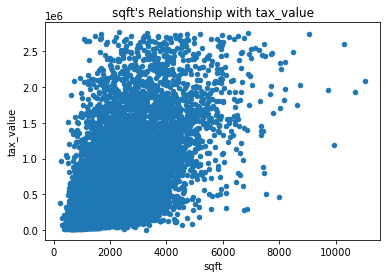

In [22]:
#squared footage and tax_value
exp.correlation_exploration(train, 'sqft', 'tax_value',t ,p)

Takeaways:

- Most distributions are normal or slightly skewed to the right, except for FIPS which most of these properties are in Los Angeles County
- Square footage has a positive correlation with tax value
- No. of bedrooms and bathrooms have a positive relationship with tax value
- Square footage tends to be bigger for properties with more bedrooms or bathrooms (as expected, sqft, number of beds/baths are all related)
- Age has a negative correlation with tax value, but according to the t test, it may not have a super drastic affect.
- Seems that properties in Los Angeles County tend to have more square footage and value than Orange County and Ventura County

## Modeling

In [23]:
X_train_scaled, X_validate_scaled, X_test_scaled = w.scaled_df(X_train, X_validate, X_test, MinMaxScaler())

In [24]:
#tells us which features we should keep from the columns I pulled. It says I should use sqft, baths, beds, and age in my model
cols = list(X_train_scaled.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print(selected_features_BE)

['number_bedroom', 'number_bathroom', 'sqft', 'geographic_code', 'tax_amount', 'age', 'tax_rate']


In [25]:
#using RFE to test for features to use. I set a range from 1-7 to see if it would use some or all of the features I pulled.
#It ends up telling us we should use four of the features to have the best model score.
number_of_features_list=np.arange(1,7)
high_score=0

#Variable to store the optimum features
number_of_features=0           
score_list =[]

for n in range(len(number_of_features_list)):
    model = LinearRegression()
    rfe = RFE(model,number_of_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train_scaled,y_train)
    X_test_rfe = rfe.transform(X_test_scaled)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        number_of_features = number_of_features_list[n]

print("Optimum number of features: %d" %number_of_features)
print("Score with %d features: %f" % (number_of_features, high_score))

Optimum number of features: 6
Score with 6 features: 0.964863


In [26]:
#let's find out which four it wants us to use
#Sqft, baths, beds, and age.
cols = list(X_train.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 4)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['number_bedroom', 'number_bathroom', 'age', 'tax_rate'], dtype='object')


In [27]:
selected_features = ['number_bathroom', 'number_bathroom', 'age']

In [28]:
#turning my y_train and y_validate to dataframes so we can append new columns
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#tax_value mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

#tax_value_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

#RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print('             BASELINE')
print('----------------------------------')
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))
print('----------------------------------')

#RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))
print('----------------------------------')
r2_baseline = r2_score(y_validate.tax_value, y_validate.tax_value_pred_mean)
print(f'The r^2 score for baseline is {r2_baseline}')

             BASELINE
----------------------------------
RMSE using Mean
Train/In-Sample:  418323.95 
Validate/Out-of-Sample:  416333.19
----------------------------------
RMSE using Median
Train/In-Sample:  430989.33 
Validate/Out-of-Sample:  428081.13
----------------------------------
The r^2 score for baseline is -9.38874827791647e-05


In [29]:
#Our first model: LinearRegression
#create model object
lm = LinearRegression(normalize=True)

#fit the model to our training data, specify column since it is a dataframe
lm.fit(X_train_scaled[selected_features],y_train.tax_value)

#predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

#predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression:\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lm = r2_score(y_validate.tax_value, y_validate.tax_value_pred_lm)
print(f'The r^2 value for linear regression is {round(r2_score_lm,3)}')

RMSE for OLS using LinearRegression:
Training/In-Sample:  353990.9580759702 
Validation/Out-of-Sample:  347500.99701707694
The r^2 value for linear regression is 0.303


In [30]:
#LassoLars 
#create model object
lars = LassoLars(alpha=1.0)

#fit the model to our training data, specify column since it is a dataframe
lars.fit(X_train_scaled[selected_features],y_train.tax_value)

#predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

#predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for OLS using Lasso+Lars\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lars = r2_score(y_validate.tax_value, y_validate.tax_value_pred_lars)
print(f'The r^2 value for LassoLars regression is {round(r2_score_lars,3)}')

RMSE for OLS using Lasso+Lars
Training/In-Sample:  353906.7516546159 
Validation/Out-of-Sample:  347420.5031805878
The r^2 value for LassoLars regression is 0.304


In [31]:
#TweedieRegressor, I found using 0 power and 0 for alpha yielded the best results...
#create model object
glm = TweedieRegressor(power =0, alpha=0.00)

#fit the model to our training data, specify column since it is a dataframe
glm.fit(X_train_scaled[selected_features],y_train.tax_value)

#predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

#predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for OLS using TweedieRegressor\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_glm = r2_score(y_validate.tax_value, y_validate.tax_value_pred_glm)
print(f'The r^2 value for TweedieRegressor is {round(r2_score_glm,3)}')

RMSE for OLS using TweedieRegressor
Training/In-Sample:  353906.5748975242 
Validation/Out-of-Sample:  347414.76770573616
The r^2 value for TweedieRegressor is 0.304


In [32]:
#making polynomial features to get a new set of features, I found that degree=3 yielded the best results.
pf = PolynomialFeatures(degree=3)

#fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled[selected_features])

#transform X_validate_scaled, and X_test_scaled
X_validate_degree3 = pf.transform(X_validate_scaled[selected_features])
X_test_degree3 = pf.transform(X_test_scaled[selected_features])

#okay let's do linear regression again with our new degree
lm3 = LinearRegression(normalize=True)

#fit the model using scaled X_train, once again specify y_train column
lm3.fit(X_train_degree3, y_train.tax_value)

#predict train
y_train['tax_value_pred_lm3'] = lm3.predict(X_train_degree3)

#evaluate rmse for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm3)**(1/2)

#predict validate
y_validate['tax_value_pred_lm3'] = lm3.predict(X_validate_degree3)

#evaluate rmse for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lm3 = round(r2_score(y_validate.tax_value, y_validate.tax_value_pred_lm3),2)
print(f'The r^2 value for TweedieRegressor is {round(r2_score_lm3,3)}')

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  344471.1179599453 
Validation/Out-of-Sample:  336869.2381812427
The r^2 value for TweedieRegressor is 0.35


In [33]:
#turning it into a dataframe
y_test = pd.DataFrame(y_test)

# predicting on our test model
y_test['tax_value_pred_lm3'] = lm3.predict(X_test_degree3)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm3)**(1/2)
print('             ')
print('             Our Test Model')
print('----------------------------------')
print('----------------------------------')
print("RMSE for OLS Model using Polynomial (3 degrees)\nOut-of-Sample Performance: ", rmse_test)
r2_test_score_lm3 = r2_score(y_test.tax_value, y_test.tax_value_pred_lm3)
print("RSME for baseline: ", rmse_validate)
print(f'Polynomial Regression (3 degrees) has an R^2 value of {round(r2_test_score_lm3,3)}')

             
             Our Test Model
----------------------------------
----------------------------------
RMSE for OLS Model using Polynomial (3 degrees)
Out-of-Sample Performance:  334417.873937558
RSME for baseline:  336869.2381812427
Polynomial Regression (3 degrees) has an R^2 value of 0.303


Takeaway:
- Our test model (Polynomial regression, 3 degrees) performs 78% better than the baseline. It has a lower RMSE, lower variance between test/validate, and has a higher r^2 value, so it can better explain the variances between predicted and actual home values.

### Conclusions, Next Steps...

To conclude... We took a very large Zillow dataset to work with. We dropped rows with outliers of 3 standard deviations above or below the mean for that column.

    - Square footage was the best feature to determine a property's value. As square footage increased, it seemed that value also went up.

    - The more bedrooms and bathrooms a house has, the more it was worth. These number of rooms also related to square footage in a positive relationship.

    - Age was not a huge factor in value, but was helpful in our model's predictions.

    - Using all of number of bedrooms, number of bathrooms, and age into a model performed better than the baseline.

With more time, I would definitely look into the other columns and see if they could contribute positively to our prediction model with some cleaning up on nulls and outliers. I believe location is still a huge factor on value, so I'd try to work with columns like latitude/longitude, zip code, etc. as FIPS was not a great indicator for value on how general it is.